<a href="https://colab.research.google.com/github/andygoosh/wildfire.sberbank.ai/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip fts_preprocessed.cvs.zip fts_preprocessed.cvs

Archive:  fts_preprocessed.cvs.zip
  inflating: fts_preprocessed.cvs    


In [109]:
!pip3 install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 6.5MB/s 


In [0]:
#sklearn.pipeline: Pipeline

In [3]:
'''
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
'''
#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras import layers
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score

import warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
#tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (18,6)


  plt.subplot(1,3,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.legend()

  plt.subplot(1,3,2)
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.plot(hist['epoch'], hist['auc'],
           label='Train AUC')
  plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Val AUC')
  plt.legend()
  
  plt.subplot(1,3,3)
  plt.xlabel('Epoch')
  plt.ylabel('Categorical Acc')
  plt.plot(hist['epoch'], hist['categorical_accuracy'],
           label='Train cat.acc.')
  plt.plot(hist['epoch'], hist['val_categorical_accuracy'],
           label = 'Val cat.acc.')
  plt.legend()
  
  plt.show()

  plt.rcParams["figure.figsize"] = old_rcparam


Populating the interactive namespace from numpy and matplotlib


1.15.0
2.2.4-tf


Using TensorFlow backend.


In [0]:
def prepare_data(one_hotted=False):

  df_features = pd.read_csv('fts_preprocessed.cvs', index_col='fire_id')
  FTS = df_features.columns[3:]
  TARGET = 'fire_type'

  X = df_features[FTS].fillna(0)
  if one_hotted == True:
    y = get_one_hot( df_features[TARGET] )
  else:
    y = df_features[TARGET]

  #X = X[[col for col in X.columns if '-' not in col]]
  #X = X[[col for col in X.columns if '_' not in col]]

  return X, y

In [0]:
'''
feat_importances = pd.Series(model.feature_importances_, index=['x%d' % i for i in range(X_poly.shape[1])])
feat_importances.nlargest(20).plot(kind='barh')

estimators = 200
params = {'random_state': RS,
  'n_estimators': estimators,
  'verbose': 0,
  }

X_p = pd.DataFrame(
    X_poly,
    index=X.index,
    columns=[ 'x%d' % i for i in range(X_poly.shape[1])
    ]
)

scores, models = fit_estimate(X_p, y, lambda: LGBMClassifier(**params))
lgbm = models[np.argmin(scores)]
'''

In [0]:
def reduce_dimentions( X, draw_graph=False ):
  pca = PCA()
  pca.fit(X)
  t = pca.transform(X)

  cols = [f"f{i:d}" for i in range(t.shape[1])]
  X = pd.DataFrame(t, index=X.index, columns=cols)

  if( draw_graph == True):
    feat_importances = pd.Series(pca.explained_variance_, index=X.columns)
    feat_importances.plot(kind='barh')

  return X

In [0]:
def get_one_hot( y ):
  columns=[ 'fire_{}_prob'.format(i) for i in range(1, 12) ]
  columns.remove('fire_7_prob')
  y_ = y.values.reshape(-1,1)
  enc = OneHotEncoder(categories='auto').fit(y_)

  return pd.DataFrame(enc.transform(y_).toarray(), index=y.index, columns=columns)

In [0]:
def draw_confusion_matrix( gt, pred, model ):
  plt.rcParams["figure.figsize"] = (6,6)
  # get rid of probability, set max prob to 1, erst to 0
  pred_max_prob = pred.apply(lambda row: row.map(lambda e: 1 if e == row.max() else 0), axis = 1)
  # do the trick
  cnf_matrix = skl.metrics.confusion_matrix(pred_max_prob.values.argmax(axis=1), gt.values.argmax(axis=1))
  class_names=pred.columns
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1)
  plt.ylabel('Predicted label')
  plt.xlabel('Actual label')

  auc = skl.metrics.roc_auc_score(gt, pred, average='micro')
  str = '{}: CV ROC AUC={:.3f}'.format(type(model).__name__, auc )
  plt.title(str, y=1)
  print(str)

  return auc

In [0]:
def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  def add_neughbors_inner( X, neigh ):
    X = X.copy()
    dists, _ = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=True)
    mean_dist = dists.mean(axis=1)
    max_dist = dists.max(axis=1)
    min_dist = dists.min(axis=1)

    X['K-mean'] = mean_dist.reshape(-1, 1)
    X['K-max'] = max_dist.reshape(-1, 1)
    X['K-min'] = min_dist.reshape(-1, 1)

    return X

  X_train = add_neughbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neughbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

In [0]:
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)

  def add_polynomial_inner( X, poly ):
    X = X.copy()
    X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
    return X
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):
    print('.', end='')

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y.iloc[train_idx], y.iloc[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()
    model.fit(X_train, y_train)

    y_pred_cv = model.predict_proba(X_cv)
    y_hotted = get_one_hot( y_cv )
    scores.append(skl.metrics.roc_auc_score(y_hotted, y_pred_cv))
    models.append(model)

  print('{:} CV mean score: {:.4f}, std: {:.4f}.'.format(type(model).__name__, np.mean(scores), np.std(scores)))
  return scores, models, neighbs, polies

In [119]:
%%time
X, y = prepare_data(one_hotted=False)
estimators = 340
params = {'boosting_type': 'gbdt', 
 'class_weight': None, 
 'colsample_bytree': 1.0, 
 'importance_type': 'split', 
 'learning_rate': 0.08, 
 'max_depth': -1, 
 'min_child_samples': 20, 
 'min_child_weight': 0.001, 
 'min_split_gain': 0.0, 
 'n_estimators': estimators, 
 'n_jobs': -1, 
 'num_leaves': 31, 
 'objective': None, 
 'random_state': 77, 
 'reg_alpha': 0.0, 
 'reg_lambda': 1.0, 
 'silent': True, 
 'subsample': 1.0, 
 'subsample_for_bin': 200000, 
 'subsample_freq': 0
 }
#goosh

scores, models, neighbors, polies = fit_estimate(X, y, 
                                         lambda: LGBMClassifier(**params), 
                                         n_folds=9, 
                                         n_neighbors=0, #5
                                         degree=2, #2
                                         )
lgbm = models[np.argmax(scores)]
poly2 = polies[np.argmax(scores)]

#..LGBMClassifier CV mean score: 0.9074, std: 0.0027. params, 340 estimators, neightb
#.........LGBMClassifier CV mean score: 0.9144, std: 0.0093. params, 340 estimators, neightb

#.........LGBMClassifier CV mean score: 0.9154, std: 0.0088. params no shift
#.........LGBMClassifier CV mean score: 0.9155, std: 0.0064. params no shift, neighb

#.........LGBMClassifier CV mean score: 0.9106, std: 0.0111. stats, no shufts

#.........LGBMClassifier CV mean score: 0.9128, std: 0.0109. no shift, no stats
#.........LGBMClassifier CV mean score: 0.9142, std: 0.0074. no shift, no stats, neighb

#.........LGBMClassifier CV mean score: 0.9201, std: 0.0113. no shift, no stats, no neighb, poly2
#.........LGBMClassifier CV mean score: 0.9195, std: 0.0123. no shift, no stats, neighb, poly2
#.........LGBMClassifier CV mean score: 0.9205, std: 0.0105. no stats, no neighb, poly3




.........LGBMClassifier CV mean score: 0.9201, std: 0.0113.
CPU times: user 12min 41s, sys: 6.49 s, total: 12min 47s
Wall time: 6min 31s


In [1]:
X, y = prepare_data(one_hotted=False)
X = pd.DataFrame(poly2.transform(X), index=X.index, columns = poly2.get_feature_names(X.columns))
perm = PermutationImportance(lgbm, random_state=RS).fit(X, y)
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

NameError: ignored

In [118]:
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

Weight,Feature
0.1472 ± 0.0042,longitude latitude
0.0717 ± 0.0009,longitude phi
0.0453 ± 0.0014,longitude temperature
0.0424 ± 0.0023,longitude
0.0370 ± 0.0016,temperature phi
0.0327 ± 0.0016,month longitude
0.0290 ± 0.0014,month phi
0.0262 ± 0.0013,temperature
0.0238 ± 0.0037,longitude humidity
0.0217 ± 0.0020,month latitude


In [0]:
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

Weight,Feature
0.1472 ± 0.0042,longitude latitude
0.0717 ± 0.0009,longitude phi
0.0453 ± 0.0014,longitude temperature
0.0424 ± 0.0023,longitude
0.0370 ± 0.0016,temperature phi
0.0327 ± 0.0016,month longitude
0.0290 ± 0.0014,month phi
0.0262 ± 0.0013,temperature
0.0238 ± 0.0037,longitude humidity
0.0217 ± 0.0020,month latitude


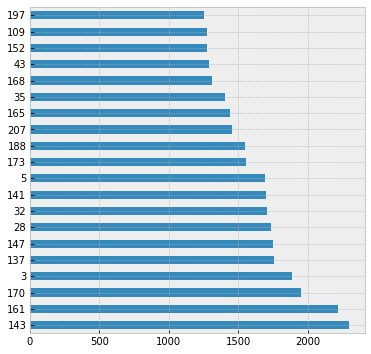

In [91]:
feat_importances = pd.Series(lgbm.feature_importances_)
feat_importances.nlargest(20).plot(kind='barh')

## NCEP Dataset

Погодные данные из проекта [NCEP Reanalysis 2](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html) — усреднённые за день температура воздуха, относительная влажность и компоненты ветра. Данные можно получить с 1979 года.

Загрузите наборы данных в каталог `data/ncep/`:
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
- https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc

In [0]:
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
!wget https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc


--2019-11-26 06:35:37--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46055656 (44M) [application/x-netcdf]
Saving to: ‘rhum.2018.nc’

rhum.2018.nc        100%[===================>]  43.92M  3.29MB/s    in 9.8s    

2019-11-26 06:35:47 (4.50 MB/s) - ‘rhum.2018.nc’ saved [46055656/46055656]

--2019-11-26 06:35:49--  https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc
Resolving www.esrl.noaa.gov (www.esrl.noaa.gov)... 140.172.253.69, 2610:20:8800:6001::45
Connecting to www.esrl.noaa.gov (www.esrl.noaa.gov)|140.172.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92099952 (88M) [application/x-netcdf]
Saving to: ‘uwnd.2018.nc’

uwnd.2018.nc        100%[===================>]  87.

In [0]:
!pip3 install catboost

## Набор признаков на основе данных NCEP

Ищем наиболее близкий к точке узел сетки в наборе NCEP, в качестве признаков значения переменных зарегистрированные в день регистрации точки и агрегированные показатели за период от 1 до 3х недель до момента регистрации точки.

In [0]:
def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    date = row['date']
    v = point.sel(time=date)
    v_dt = pd.to_datetime(v.time.values.item(0))

    ## add obvious features
    all_features = {
        'fire_id': row['fire_id'],
        'fire_type': row['fire_type'], # change for '' while submitting
        'fire_type_name': row['fire_type_name'], # change for '' while submitting
        'date': row['date'], 
        'day': v_dt.day,
        'month': v_dt.month,
        'longitude': row['longitude'],
        'latitude': row['latitude'],
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
    }

    ## spherical coords
    degrees_to_radians = math.pi/180.0
    # phi = 90 - latitude
    phi = (90.0 - row['latitude'])*degrees_to_radians
    # theta = longitude
    theta = row['longitude']*degrees_to_radians
    all_features['phi'] = phi
    all_features['theta'] = theta

    ## add shifts and deltas
    for i in range(1, 8):
      y_dt = v_dt - timedelta(days=i)
      if(y_dt.year < 2018):
        prev_day = date
      else:
        prev_day = y_dt.strftime("%F")
      y = point.sel(time=prev_day)

      all_features['t-%d' % i] = y.air.values.item(0)
      all_features['h-%d' % i] = y.rhum.values.item(0)
      all_features['u-%d' % i] = y.uwnd.values.item(0)

      all_features['dt-%d' % i] = v.air.values.item(0) - y.air.values.item(0)
      all_features['dh-%d' % i] = v.rhum.values.item(0) - y.rhum.values.item(0)
      all_features['du-%d' % i] = v.uwnd.values.item(0) - y.uwnd.values.item(0)

    ## add aggregations
    PERIODS = [7, 14, 21, 28]
    AGGREGATES = ["mean", "median", "std", "max", "min"]
    for period in PERIODS:
        rolling_features = point.rolling(time=period)
        for agg in AGGREGATES:
            agg_function = getattr(rolling_features, agg)
            rolling_result = agg_function().sel(time=date)

            name_t = "_".join(['t', str(period), agg])
            all_features[name_t] = rolling_result.air.values.item(0)

            name_h = "_".join(['h', str(period), agg])
            all_features[name_h] = rolling_result.rhum.values.item(0)

            name_u = "_".join(['u', str(period), agg])
            all_features[name_u] = rolling_result.uwnd.values.item(0)

    return all_features

## Подготовка выборки для обучения

In [0]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = '{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename,),)
ncep_data = xarray.merge(ncep_data)

df_train = pd.read_csv('wildfires_train.csv')
df_subsample = df_train.query('(date > "2018") & (date < "2019")')

df_features = []
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):

    features = extract_features(row)
    df_features.append(features)

df_features = pd.DataFrame(df_features)
df_features.set_index('fire_id', inplace=True)
df_features.to_csv('fts_preprocessed.cvs', index_label='fire_id')

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'uwnd' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:394: SerializationWarning: variable 'rhum' has multiple fill values {-99, 32767}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


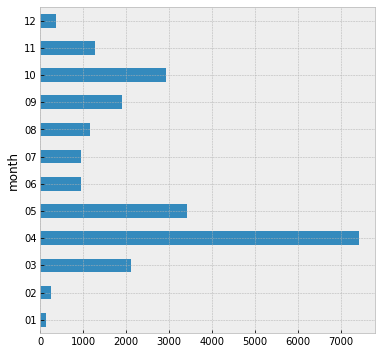

In [0]:
a = pd.read_csv('wildfires_train.csv')
a = a.query('(date > "2018") & (date < "2019")')

a['month'] = a.date.map(lambda x: x.split('-')[1])

b = a.fire_id.groupby(a.month).count()
b.plot.barh()

In [0]:
a

,fire_id,date,latitude,longitude,fire_type,fire_type_name,month
136040,136040,2018-01-01,55.902280,98.080232,3,горение мусора,01
136041,136041,2018-01-01,54.216790,87.565010,9,природный пожар,01
136042,136042,2018-01-01,56.961032,97.716761,3,горение мусора,01
136043,136043,2018-01-01,52.456409,113.301796,4,сжигание порубочных остатков,01
136044,136044,2018-01-02,50.798930,108.130196,4,сжигание порубочных остатков,01
...,...,...,...,...,...,...,...
158855,158855,2018-12-29,43.740941,131.300458,6,неконтролируемый пал,12
158856,158856,2018-12-29,42.684450,131.223432,6,неконтролируемый пал,12
158857,158857,2018-12-29,44.287796,132.428538,6,неконтролируемый пал,12
158858,158858,2018-12-29,43.483922,131.859177,6,неконтролируемый пал,12


In [0]:
df_features

,fire_type,fire_type_name,date,day,month,longitude,latitude,temperature,humidity,uwind,t_7_mean,h_7_mean,u_7_mean,t_7_median,h_7_median,u_7_median,t_7_std,h_7_std,u_7_std,t_7_max,h_7_max,u_7_max,t_7_min,h_7_min,u_7_min,t_14_mean,h_14_mean,u_14_mean,t_14_median,h_14_median,u_14_median,t_14_std,h_14_std,u_14_std,t_14_max,h_14_max,u_14_max,t_14_min,h_14_min,u_14_min,t_21_mean,h_21_mean,u_21_mean,t_21_median,h_21_median,u_21_median,t_21_std,h_21_std,u_21_std,t_21_max,h_21_max,u_21_max,t_21_min,h_21_min,u_21_min,t_28_mean,h_28_mean,u_28_mean,t_28_median,h_28_median,u_28_median,t_28_std,h_28_std,u_28_std,t_28_max,h_28_max,u_28_max,t_28_min,h_28_min,u_28_min
fire_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156306,4,сжигание порубочных остатков,2018-10-19,10,19,32.817378,53.629106,289.489990,62.210007,1.099991,288.611420,56.221474,1.578568,289.099976,57.770004,1.099991,1.734554,4.974678,1.374208,291.149994,62.210007,3.569992,286.390015,46.399994,-0.410004,286.483215,62.770710,1.447140,286.174988,62.125000,1.399994,2.706630,8.180873,2.012869,291.149994,75.089996,4.690002,281.049988,46.399994,-3.050003,285.048981,65.120476,2.008093,285.209991,66.500000,1.699997,3.142212,8.591250,2.335866,291.149994,77.240005,7.869995,279.700012,46.399994,-3.050003,285.043488,67.059662,2.660355,284.695007,69.195000,2.599998,3.574846,9.435399,2.524624,295.260010,81.539993,7.869995,279.700012,46.399994,-3.050003
141151,11,не подтверждено,2018-04-14,4,14,33.288874,55.158507,280.979980,47.699997,-1.940002,281.634338,52.944279,-0.521432,280.880005,55.779999,-0.660004,3.122652,7.996476,2.458827,287.950012,61.830002,3.099991,277.940002,37.980011,-4.089996,279.822144,69.292854,-0.157146,279.744995,64.830002,-0.605003,3.390145,18.253689,2.961337,287.950012,96.330002,4.889999,275.399994,37.980011,-4.720001,277.002838,72.166183,0.188092,277.279999,80.830002,0.289993,5.078269,17.716551,2.661560,287.950012,96.330002,4.889999,268.020020,37.980011,-4.720001,275.296112,73.953232,0.732140,275.335022,80.605003,0.610001,5.523023,15.691216,2.604454,287.950012,96.330002,5.169998,263.669983,37.980011,-4.720001
153769,10,контролируемый пал,2018-09-24,9,24,116.875240,62.923579,281.410004,77.190002,1.679993,280.072632,71.319992,1.664283,280.399994,68.949997,1.569992,1.147348,5.448310,1.343671,281.410004,79.589996,4.050003,278.339996,64.559998,-0.479996,279.706512,71.865730,0.107855,279.524994,69.004997,0.489998,1.252412,8.104973,2.225845,281.410004,88.169998,4.050003,277.289978,58.889999,-4.169998,279.004089,70.065742,0.313807,279.020020,68.759995,0.660004,1.789414,8.114033,2.145920,281.410004,88.169998,4.050003,275.160004,58.889999,-4.169998,280.699677,71.038925,0.507855,279.524994,69.004997,0.994995,4.011778,8.468513,1.984817,290.890015,88.169998,4.050003,275.160004,58.800003,-4.169998
143153,11,не подтверждено,2018-04-21,4,21,38.099304,55.747030,287.299988,65.729996,5.389999,285.175781,62.898563,2.214284,284.450012,65.729996,2.029999,2.187356,11.030473,1.694622,288.839996,75.449997,5.389999,282.649994,41.769989,0.059998,282.556396,59.942188,1.343570,282.815002,63.324997,1.864998,3.858957,10.717012,2.354969,288.839996,75.449997,5.389999,276.869995,40.109985,-2.970001,280.580414,69.169525,1.007142,279.209991,68.899994,1.699997,4.346039,16.241674,2.521338,288.839996,96.779999,5.389999,274.750000,40.109985,-3.020004,278.073547,71.722145,1.206784,277.589996,70.104996,1.599998,5.915634,15.934000,2.302690,288.839996,96.779999,5.389999,267.200012,40.109985,-3.020004
154105,10,контролируемый пал,2018-09-28,9,28,116.519039,63.220488,278.619995,80.929993,1.809998,281.326904,77.658554,1.902854,281.410004,77.190002,1.789993,1.305207,5.941737,1.229540,283.289978,89.149994,4.050003,278.619995,70.539993,-0.290009,280.565094,75.638588,1.224997,280.744995,75.464996,1.305000,1.373229,7.669961,1.202590,283.289978,89.149994,4.050003,278.339996,64.559998,-0.479996,279.581207,71.855263,0.202378,279.089996,70.539993,0.660004,1.922948,8.679314,2.003309,283.289978,89.14999

## Линейные алго

In [0]:
#e = y.groupby(y).count()
#e.plot.barh()
#e

## Подбор параметров

## Гридсерч

In [0]:
X, y = prepare_data(one_hotted=False)

gb = skl.ensemble.GradientBoostingClassifier(random_state=RS)
ab = skl.ensemble.AdaBoostClassifier(random_state=RS)

parameters_ab = { 
    'n_estimators':np.linspace(1, 100, 10).astype(int), 
    'learning_rate':np.logspace(0, 100, 10), 
    }

parameters_gb = { 
    'n_estimators':[300, 400, 500, 700], 
    'learning_rate':[0.03, 0.035, 0.039], 
    'max_depth': [2, 3,4, 5], 
    'min_samples_split': [3, 10, 20, 50],
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    }

GS = GridSearchCV(ab, parameters_ab, cv=KFold( n_splits = 5, shuffle=True, random_state=RS),verbose=10, n_jobs=-1)
GS.fit(X, y)
print( GS.best_params_ )
print( GS.best_score_ )

RS = RandomizedSearchCV(gb, )

## Рандомайзед серч

In [0]:
skl.ensemble.GradientBoostingClassifier().get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [0]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(one_hotted=False)

gb = skl.ensemble.GradientBoostingClassifier()

parameters_gb = { 
    'n_estimators': sp_randInt(10, 1000),  # 100
    'learning_rate': sp_randFloat(),  # 0.1
    'max_depth': sp_randInt(1, 10),  # 1.0
    'min_samples_split': sp_randInt(3, 50),
    "min_samples_leaf": sp_randFloat(0, 1),
    "subsample": sp_randFloat(),
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "loss": ["deviance", "exponential"]
    }

RS = RandomizedSearchCV(gb, 
                        param_distributions=parameters_gb, 
                        cv=2, 
                        verbose=1, 
                        n_iter=10, 
                        scoring='f1_micro',
                        n_jobs=-1)
RS.fit(X, y)
print( RS.best_params_ )
print( RS.best_score_ )

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.3min finished


{'criterion': 'friedman_mse', 'learning_rate': 0.012299611487293416, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.2471251936343346, 'min_samples_split': 42, 'n_estimators': 446, 'subsample': 0.8342330592302794}
0.48675


## Проверка результата поиска

## LGBMClassifier

In [0]:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 77, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0.9620823406568829

In [0]:
print(lgbm.get_params())
print(auc)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 77, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
0.9620823406568829


In [0]:
LGBMClassifier CV mean score: 0.9087, std: 0.0093. all fts / default params
LGBMClassifier CV mean score: 0.9056, std: 0.0056. best fts / default params
LGBMClassifier CV mean score: 0.9062, std: 0.0067. best fts / best params
LGBMClassifier CV mean score: 0.9078, std: 0.0055. all fts / best params


In [62]:
X, y = prepare_data(one_hotted=False)
X

,day,month,longitude,latitude,temperature,humidity,uwind,phi,theta,t-1,h-1,u-1,dt-1,dh-1,du-1,t-2,h-2,u-2,dt-2,dh-2,du-2,t-3,h-3,u-3,dt-3,dh-3,du-3,t-4,h-4,u-4,dt-4,dh-4,du-4,t-5,h-5,u-5,dt-5,dh-5,du-5,t-6,...,u_14_median,t_14_std,h_14_std,u_14_std,t_14_max,h_14_max,u_14_max,t_14_min,h_14_min,u_14_min,t_21_mean,h_21_mean,u_21_mean,t_21_median,h_21_median,u_21_median,t_21_std,h_21_std,u_21_std,t_21_max,h_21_max,u_21_max,t_21_min,h_21_min,u_21_min,t_28_mean,h_28_mean,u_28_mean,t_28_median,h_28_median,u_28_median,t_28_std,h_28_std,u_28_std,t_28_max,h_28_max,u_28_max,t_28_min,h_28_min,u_28_min
fire_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
136040,1,1,98.080232,55.902280,253.160004,87.479996,0.229996,0.595117,1.711823,253.160004,87.479996,0.229996,0.000000,0.000000,0.000000,253.160004,87.479996,0.229996,0.000000,0.000000,0.000000,253.160004,87.479996,0.229996,0.000000,0.000000,0.000000,253.160004,87.479996,0.229996,0.000000,0.000000,0.000000,253.160004,87.479996,0.229996,0.000000,0.000000,0.000000,253.160004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
136041,1,1,87.565010,54.216790,253.479996,94.029999,-0.809998,0.624535,1.528298,253.479996,94.029999,-0.809998,0.000000,0.000000,0.000000,253.479996,94.029999,-0.809998,0.000000,0.000000,0.000000,253.479996,94.029999,-0.809998,0.000000,0.000000,0.000000,253.479996,94.029999,-0.809998,0.000000,0.000000,0.000000,253.479996,94.029999,-0.809998,0.000000,0.000000,0.000000,253.479996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
136042,1,1,97.716761,56.961032,249.009995,99.130005,1.490005,0.576639,1.705479,249.009995,99.130005,1.490005,0.000000,0.000000,0.000000,249.009995,99.130005,1.490005,0.000000,0.000000,0.000000,249.009995,99.130005,1.490005,0.000000,0.000000,0.000000,249.009995,99.130005,1.490005,0.000000,0.000000,0.000000,249.009995,99.130005,1.490005,0.000000,0.000000,0.000000,249.009995,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
136043,1,1,113.301796,52.456409,255.229996,89.630005,1.770004,0.655259,1.977489,255.229996,89.630005,1.770004,0.000000,0.000000,0.000000,255.229996,89.630005,1.770004,0.000000,0.000000,0.000000,255.229996,89.630005,1.770004,0.000000,0.000000,0.000000,255.229996,89.630005,1.770004,0.000000,0.000000,0.000000,255.229996,89.630005,1.770004,0.000000,0.000000,0.000000,255.229996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
136044,2,1,108.130196,50.798930,256.910004,92.300003,0.690002,0.684188,1.887228,259.359985,92.130005,1.580002,-2.449982,0.169998,-0.889999,256.910004,92.300003,0.690002,0.000000,0.000000,0.000000,256.910004,92.300003,0.690002,0.000000,0.000000,0.000000,256.910004,92.300003,0.690002,0.000000,0.000000,0.000000,256.910004,92.300003,0.690002,0.000000,0.

In [24]:
from lightgbm import LGBMClassifier

X, y = prepare_data(one_hotted=False)

estimators = 340

params = {'boosting_type': 'gbdt', 
 'class_weight': None, 
 'colsample_bytree': 1.0, 
 'importance_type': 'split', 
 'learning_rate': 0.08, 
 'max_depth': -1, 
 'min_child_samples': 20, 
 'min_child_weight': 0.001, 
 'min_split_gain': 0.0, 
 'n_estimators': estimators, 
 'n_jobs': -1, 
 'num_leaves': 31, 
 'objective': None, 
 'random_state': 77, 
 'reg_alpha': 0.0, 
 'reg_lambda': 1.0, 
 'silent': True, 
 'subsample': 1.0, 
 'subsample_for_bin': 200000, 
 'subsample_freq': 0
 }

def_params = {'random_state': RS,
  'n_estimators': estimators,
}

scores, models = fit_estimate(X, y, lambda: LGBMClassifier(**params), n_folds=5, neighbors=True)
lgbm = models[np.argmax(scores)]

#.....LGBMClassifier CV mean score: 0.9102, std: 0.0082.  params, 340 estimators, neightb, 5 fold

.....LGBMClassifier CV mean score: 0.9102, std: 0.0082.


In [0]:
lgbm = models[np.argmax(scores)]

In [0]:
feat_importances = pd.Series(lgbm.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
eli5.show_weights(lgbm, top=50)

In [0]:
perm = PermutationImportance(lgbm, random_state=RS).fit(X, y)
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

In [66]:
pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.002]['feature'].tolist()
print(pi_features)

['longitude', 'latitude', 'phi', 'month', 'h_14_median', 'h_7_median', 'u_28_mean', 'dt-7', 'h_28_min', 'h-1', 'temperature', 'du-2', 'h_21_max', 't-7', 'h_28_median', 't_28_min', 'u_28_min', 't_28_median', 'u_28_std', 't_21_std', 't-5', 'h_14_mean', 'h_28_max', 't_7_max', 't_28_std', 'du-7', 'u_28_median', 'dh-3', 'h-4', 't_14_std', 'dt-3', 'h_21_min', 'h_14_max', 'du-5', 'h_28_std', 't_21_max', 'dh-2', 'day', 't_14_max', 'u-7', 'dt-2', 'h_7_std', 'dt-4', 't_7_std', 't-1', 't_21_median', 'h_14_std', 'h-5', 'dt-1', 'u-1', 'h_7_max', 'u_21_max', 't-6', 'u-2', 'u_14_std', 't-2', 'dt-6', 'u_21_std', 'u-5', 'u_14_max', 'h-3', 'u_28_max', 'dh-7', 'h_7_mean', 'u_14_median', 'dh-1', 'u-3', 'h_21_mean', 'h_14_min', 't_14_min', 'u_7_min', 'dh-5', 'u_14_min', 'dh-6', 'uwind', 't_21_min', 'u_7_std', 't-4']


## XGBClassifier

In [0]:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': -1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 77, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.5, 'verbosity': 1}
0.9582073349629758

In [0]:
print(xgb.get_params())
print(auc)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': -1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 77, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.5, 'verbosity': 1}
0.9582073349629758


In [103]:
from xgboost import XGBClassifier

X, y = prepare_data(one_hotted=False)

X = X[[col for col in X.columns if '-' not in col]]
X = X[[col for col in X.columns if '_' not in col]]

estimators = 200
params = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1, # values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
 'gamma': 0, #0 acts as a regularization parameter. Either 0, 1 or 5
 'learning_rate': 0.1, # usually between 0.1 and 0.01. If you’re focused on performance and have time in front of you, decrease incrementally the learning rate while increasing the number of trees.
 'max_delta_step': 0,
 'max_depth': 5, # increasing it incrementally by 1 and stopping when no performance gain
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': estimators,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': RS,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.5,
 'verbosity': 1
}

scores, models, neighbors, poly = fit_estimate(X, y, 
                                         lambda: XGBClassifier(**params), 
                                         n_folds=9, 
                                         n_neighbors=0, #5
                                         degree=2,
                                         )
xgb = models[np.argmax(scores)]

.........XGBClassifier CV mean score: 0.9170, std: 0.0122.


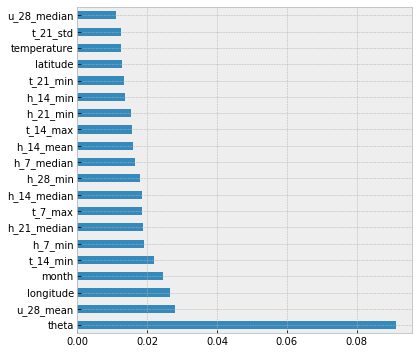

In [71]:
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
perm = PermutationImportance(xgb, random_state=RS).fit(X, y)
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.002]['feature'].tolist()
print(pi_features)

In [73]:
print(pi_features)

['longitude', 'latitude', 'month', 'h-2', 'h_21_max', 'h_28_min', 't_28_std', 'dt-7', 'u_28_std', 'temperature', 'dt-3', 'h_14_min', 'u_28_min', 't-7', 't_7_max', 'u_28_mean', 'dt-4', 'du-2', 'u_14_mean', 'u_28_max', 'h_28_max', 'dh-7', 'h_28_std', 't_28_min', 'u-2', 'dh-5', 'h-1', 'du-5', 't_21_std', 'h_14_std', 'u-7', 'h_7_max', 'du-7', 't_7_std', 'h-6', 'u_14_std', 'du-6', 'u-5', 'u_28_median', 'u_14_median', 'u_21_median', 'u_7_std', 'u-3', 'h_21_std', 'humidity', 'dh-1', 't-3', 'dh-2', 'u-4', 'h_14_mean', 'u-6', 'dh-3', 'du-3', 'h_7_median', 'dt-1', 'uwind', 'h-4', 'dh-6']


## GradientBoostingClassifier

In [0]:
print(gbc.get_params())
print(auc)

{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 77, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.9529617701020464


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


GradientBoostingClassifier: CV ROC AUC=0.948


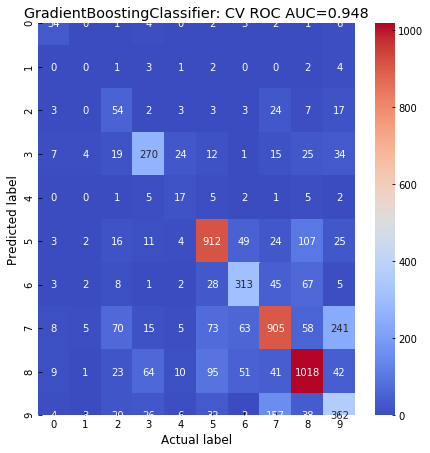

In [0]:
X, y = prepare_data(one_hotted=False)

estimators = 200
gb_params = {'criterion': 'friedman_mse', 
  'init': None, 
  'learning_rate': 0.08, 
  'loss': 'deviance', 
  'max_depth': 5, 
  'max_features': None, 
  'max_leaf_nodes': None, 
  'min_impurity_decrease': 0.0, 
  'min_impurity_split': None, 
  'min_samples_leaf': 1, 
  'min_samples_split': 15, 
  'min_weight_fraction_leaf': 0.0, 
  'n_estimators': estimators, 
  'n_iter_no_change': None, 
  'presort': 'auto', 
  'random_state': RS, 
  'subsample': 1.0, 
  'tol': 0.0001, 
  'validation_fraction': 0.1, 
  'verbose': 0, 
  'warm_start': False
  }

gb_params = {'random_state': RS,
  'n_estimators': estimators,
}

gbc = skl.ensemble.GradientBoostingClassifier(**gb_params)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

gbc.fit(X_train, y_train)

y_pred = gbc.predict_proba(X_cv)

df_predictions = pd.DataFrame(
    y_pred,
    index=y_cv.index,
    columns=[
        'fire_{}_prob'.format(class_id)
        for class_id in gbc.classes_
    ]
)

y_hotted = get_one_hot( y_cv )
auc = draw_confusion_matrix(y_hotted, df_predictions, gbc);

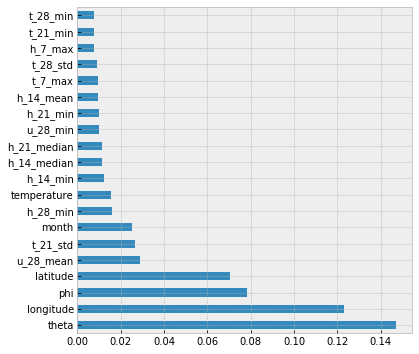

In [0]:
feat_importances = pd.Series(gbc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
perm = PermutationImportance(gbc, random_state=RS).fit(X, y)
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

In [0]:
pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.01]['feature'].tolist()
print( pi_features )

## Вычисление финального значения

## Воутинг

In [32]:
X, y = prepare_data(one_hotted=False)



xgb_params = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1, 
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': RS,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.5,
 'verbosity': 1
}

lgbm_params = {'boosting_type': 'gbdt', 
 'class_weight': None, 
 'colsample_bytree': 1.0, 
 'importance_type': 'split', 
 'learning_rate': 0.1, 
 'max_depth': -1, 
 'min_child_samples': 20, 
 'min_child_weight': 0.001, 
 'min_split_gain': 0.0, 
 'n_estimators': 340, 
 'n_jobs': -1, 
 'num_leaves': 31, 
 'objective': None, 
 'random_state': 77, 
 'reg_alpha': 0.0, 
 'reg_lambda': 1.0, 
 'silent': True, 
 'subsample': 1.0, 
 'subsample_for_bin': 200000, 
 'subsample_freq': 0
 }

gbc_params = {'criterion': 'friedman_mse', 
  'init': None, 
  'learning_rate': 0.07, 
  'loss': 'deviance', 
  'max_depth': 5, 
  'max_features': None, 
  'max_leaf_nodes': None, 
  'min_impurity_decrease': 0.0, 
  'min_impurity_split': None, 
  'min_samples_leaf': 1, 
  'min_samples_split': 15, 
  'min_weight_fraction_leaf': 0.0, 
  'n_estimators': 100, 
  'n_iter_no_change': None, 
  'presort': 'auto', 
  'random_state': RS, 
  'subsample': 1.0, 
  'tol': 0.0001, 
  'validation_fraction': 0.1, 
  'verbose': 0, 
  'warm_start': False
  }

estimators = 100
def_params = {'random_state': RS,
  'n_estimators': estimators,
}

xgb = XGBClassifier(**xgb_params)
lgbm = LGBMClassifier(**lgbm_params)
gbc = GradientBoostingClassifier(**gbc_params)

#eclf = skl.ensemble.VotingClassifier(estimators=[('gbc', gbc), ('xgb', xgb), ('lgbm', lgbm)], 

scores, models = fit_estimate(X, y, lambda: skl.ensemble.VotingClassifier(estimators=[('gbc', gbc), ('xgb', xgb), ('lgbm', lgbm)], 
                                     voting='soft', 
                                     weights=[1, 2, 2]
                                     ),
                              n_folds=2,
                              neighbors=True)
eclf = models[np.argmin(scores)]

# .....VotingClassifier CV mean score: 0.9036, std: 0.0073. all fts, default params, -gbc
#.....VotingClassifier CV mean score: 0.9027, std: 0.0072. all fts, default params, +gbc

..VotingClassifier CV mean score: 0.9066, std: 0.0028.


In [0]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X, y = prepare_data(one_hotted=False)

sfs1 = SFS(eclf, 
           k_features=30, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y, custom_feature_names=X.columns)

X_sfs = X[list(sfs1.k_feature_names_)]

In [0]:
perm = PermutationImportance(eclf, random_state=RS, verbose=10).fit(X, y)
eli5.show_weights(perm, top=50, feature_names = X.columns.tolist())

pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.002]['feature'].tolist()
pi_features

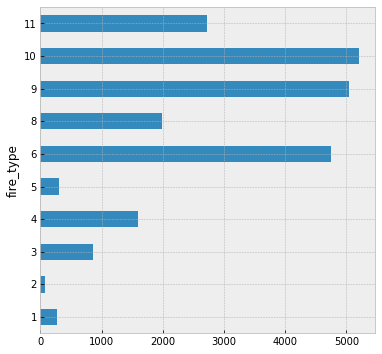

In [129]:
a = pd.read_csv('wildfires_train.csv')
a = a.query('(date > "2018") & (date < "2019")')
b = a.fire_id.groupby(a.fire_type).count()
b.plot.barh()

In [0]:
_, y = prepare_data(one_hotted=False)
class_weights = skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)

In [124]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 8.268115942028986,
 1: 30.026315789473685,
 2: 2.6320645905420994,
 3: 1.4370277078085643,
 4: 7.6066666666666665,
 5: 0.48102866779089376,
 6: 1.144433299899699,
 7: 0.4521497919556172,
 8: 0.43783576362240983,
 9: 0.8402061855670103}

## Нейронка

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 111)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 12)                5952      
_________________________________________________________________
dense (Dense)                (None, 10)                130       
Total params: 6,082
Trainable params: 6,082
Non-trainable params: 0
_________________________________________________________________


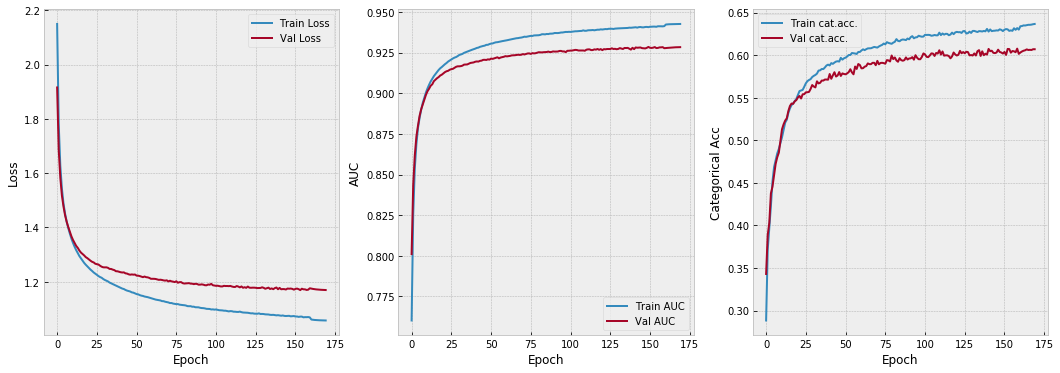

loss: 1.063, AUC: 0.942 Cat.Acc.: 0.634
loss: 1.171, AUC: 0.928 Cat.Acc.: 0.602


In [127]:
tf.keras.backend.clear_session()

_, y = prepare_data(one_hotted=False)
class_weights = skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))

X, y = prepare_data(one_hotted=True)

EPOCHS = 1000
BS = 256
WINDOW = 0
FOLDS = 10
FIRE_TYPE_NUM = y.shape[1]
degree = 0
n_neighbors = 5

polies = []
neighbs = []
                                             
tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

center, scale = tr_data.mean().values, tr_data.std().values
trn = (tr_data.values - center)/scale
cvn = (cv_data.values - center)/scale

center.tofile('center.bin')
scale.tofile('scale.bin')

#if degree > 1:
#  tr_data, cv_data, poly = add_polynomial(tr_data, cv_data, degree)
#  polies.append(poly)

#if n_neighbors > 0:
#  tr_data, cv_data, neigh = add_neighbors(tr_data, cv_data, n_neighbors)
#  neighbs.append(neigh)

FEATURES_NUM = tr_data.shape[1]

weight_decay = 0.0005
model = keras.Sequential([
    layers.Input(shape=[FEATURES_NUM]),
    layers.Reshape(target_shape=[1, FEATURES_NUM]),
    layers.LSTM(12, activation='relu', kernel_initializer='random_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)),
    #layers.LSTM(14, return_sequences=True),
    #layers.LSTM(14),
    layers.Dense(FIRE_TYPE_NUM, kernel_initializer='random_uniform', activation='softmax'),
  ])
optimizer=keras.optimizers.RMSprop(lr=1e-2)
model.compile(optimizer='adam', 
              metrics=[tf.keras.metrics.AUC(), 
                        tf.keras.metrics.categorical_accuracy
                        ], 
              loss=keras.losses.CategoricalCrossentropy() #tf.keras.losses.Huber())
              ) 

model.summary()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.01, patience=10, monitor='val_auc', mode='max')
early_stop = keras.callbacks.EarlyStopping( patience=20, monitor='val_auc', mode='max' ) #, restore_best_weights=True)
#early_stop = keras.callbacks.EarlyStopping( patience=50, monitor='val_loss', mode='min' )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_auc', mode='max', save_best_only=True )
#model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )

callbacks = [ early_stop, 
        model_save, 
        #TensorBoard(log_dir='.'),
        lr_schedule 
        ]

model.reset_states()
history = model.fit(trn, y_trn.values,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=True,
          use_multiprocessing=True,
          verbose=0,
          #class_weight=class_weights,
          validation_data=(cvn, y_cv.values),
          callbacks=callbacks)
model = keras.models.load_model('my_checkpoint.h5')

plot_history(history)

score = model.evaluate(trn, y_trn.values, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

score = model.evaluate(cvn, y_cv.values, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))

model.reset_states()

loss: 1.539, AUC: 0.875 Cat.Acc.: 0.455
1.539339745201425 0.8748689 0.4553316
tr: ROC AUC=0.875
cv: ROC AUC=0.862
Sequential: CV ROC AUC=0.862


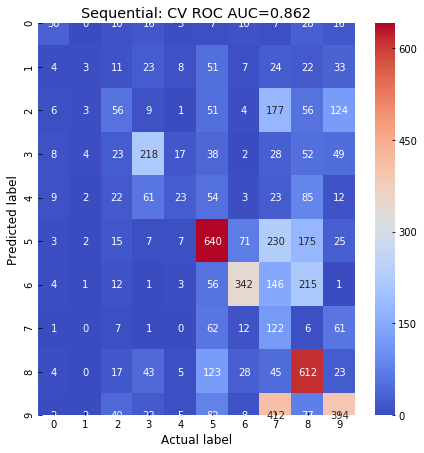

In [126]:
tr_data, cv_data, y_trn, y_cv = train_test_split(X, y, test_size=0.25, random_state=RS)

#if degree > 1:
#  tr_data, cv_data, poly = add_polynomial(tr_data, cv_data, degree)
#  polies.append(poly)

#if n_neighbors > 0:
#  tr_data, cv_data, neigh = add_neighbors(tr_data, cv_data, n_neighbors)
#  neighbs.append(neigh)

trn = (tr_data.values - center)/scale
cvn = (cv_data.values - center)/scale

tr_preds = pd.DataFrame(model.predict(trn, use_multiprocessing=True), index=y_trn.index, columns=y_trn.columns)
cv_preds = pd.DataFrame(model.predict(cvn, use_multiprocessing=True), index=y_cv.index, columns=y_cv.columns)

score = model.evaluate(trn, y_trn.values, 
                         batch_size=BS, 
                         verbose=0,
                         use_multiprocessing=True)
print('loss: {:.3f}, AUC: {:.3f} Cat.Acc.: {:.3f}'.format(*score))
print(*score)

auc_trn = skl.metrics.roc_auc_score(y_trn, tr_preds, average='micro')
auc_cv = skl.metrics.roc_auc_score(y_cv, cv_preds, average='micro')
print('tr: ROC AUC=%.3f' % (auc_trn))
print('cv: ROC AUC=%.3f' % (auc_cv))

draw_confusion_matrix( y_cv, cv_preds, model);

## Решение для отправки в систему

In [0]:
import pickle

with open('model.pickle', 'wb') as fout:
    pickle.dump(lgbm, fout, protocol=pickle.HIGHEST_PROTOCOL)

with open('ply.pickle', 'wb') as fout:
    pickle.dump(poly2, fout, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
df_predictions.insert (6, 'fire_7_prob', 0.0)
df_predictions.to_csv('sample_predictions.csv', index_label='fire_id')